In [11]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=1):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")

seed_everything(8)

🔒 Locked Random Seed: 8


In [12]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from model import DragonNetBase, tarreg_loss, dragonnet_loss, EarlyStopper

In [13]:
#load data
df_women =pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Women.csv")
df_women = df_women.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_women.isnull().sum())
print ("---------------------------")
print(df_women.dtypes)
print ("---------------------------")
print ("labels:")
print(df_women.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_women.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42693, 12)


In [14]:
#Hillstrom-men
#split num and cate

cate_cols = ['zip_code', 'channel']
df_women["history_segment"] =df_women["history_segment"].map({
    "1) $0 - $100": '1', 
    "2) $100 - $200": 2, 
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"                         
})
num_cols = ['recency', "history", 'history_segment']
#split x y t
y_women = df_women["spend"]
t_women = df_women["treatment"]
x_women = df_women.drop(columns=["spend", "treatment", "visit", "conversion"])

x_women_encode = pd.get_dummies(x_women, columns=cate_cols, drop_first=True)
x_women_encode = x_women_encode.astype(int)
#train test split
x_women_train, x_women_test_val,t_women_train, t_women_test_val, y_women_train, y_women_test_val = train_test_split(x_women_encode,t_women.values, y_women.values, test_size=0.4, random_state=42, stratify=t_women)
x_women_val, x_women_test, t_women_val, t_women_test, y_women_val, y_women_test = train_test_split(x_women_test_val, t_women_test_val, y_women_test_val, test_size= 0.75, random_state=42, stratify=t_women_test_val)

#scale
scaler = StandardScaler()
x_women_train[num_cols]= scaler.fit_transform(x_women_train[num_cols])
x_women_val[num_cols]= scaler.transform(x_women_val[num_cols])
x_women_test[num_cols] = scaler.transform(x_women_test[num_cols])

x_women_train = x_women_train.values.astype(float)
x_women_val = x_women_val.values.astype(float)
x_women_test = x_women_test.values.astype(float)
print (x_women_train)

[[ 0.35139692 -0.31812687 -0.17356238 ...  1.          0.
   1.        ]
 [ 1.20551984  0.3324775   0.21553513 ...  1.          0.
   1.        ]
 [-1.35684892  0.98308187  0.97387826 ...  0.          0.
   0.        ]
 ...
 [ 1.77493512  0.3324775   0.01304561 ...  1.          1.
   0.        ]
 [ 0.35139692  2.2842906   2.28013421 ...  0.          0.
   0.        ]
 [-1.35684892  0.98308187  0.79124065 ...  1.          1.
   0.        ]]


In [15]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_women_train_t = to_tensor(x_women_train)
x_women_val_t = to_tensor(x_women_val)
x_women_test_t = to_tensor(x_women_test)

y_women_train_t = to_tensor(y_women_train).unsqueeze(1)
y_women_val_t = to_tensor(y_women_val).unsqueeze(1)
y_women_test_t = to_tensor(y_women_test).unsqueeze(1)

t_women_train_t = to_tensor(t_women_train.astype(float)).unsqueeze(1)
t_women_val_t = to_tensor(t_women_val.astype(float)).unsqueeze(1)
t_women_test_t = to_tensor(t_women_test.astype(float)).unsqueeze(1)

#Data loader
train_dataset = TensorDataset(x_women_train_t, t_women_train_t, y_women_train_t)
val_dataset = TensorDataset(x_women_val_t, t_women_val_t, y_women_val_t)
test_dataset = TensorDataset(x_women_test_t, t_women_test_t, y_women_test_t)

batch_size =64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_women_train_t.shape}; y ={y_women_train_t.shape}; t={t_women_train_t.shape}")
print (f"Shape of val: x={x_women_val_t.shape}; y={y_women_val_t.shape}; t={t_women_val_t.shape}")
print (f"Shape of test: x={x_women_test_t.shape}; y={y_women_test_t.shape}; t={t_women_test_t.shape}")



-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25615, 10]); y =torch.Size([25615, 1]); t=torch.Size([25615, 1])
Shape of val: x=torch.Size([4269, 10]); y=torch.Size([4269, 1]); t=torch.Size([4269, 1])
Shape of test: x=torch.Size([12809, 10]); y=torch.Size([12809, 1]); t=torch.Size([12809, 1])


Evaluation metrics

In [16]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [17]:
from dragonnet import DragonNet

In [18]:
dragonnet = DragonNet(input_dim=x_women_train_t.shape[1], epochs=50, alpha = 1.0, beta =1.0, lr=0.001)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

Begin training Dragonnet Baseline🔃🔃🔃 
Epoch 1 | Train Loss: 28115.6294 | VAL LOSS: 11442.1061
Epoch 2 | Train Loss: 28085.3057 | VAL LOSS: 12073.7728
Epoch 3 | Train Loss: 28122.3034 | VAL LOSS: 11451.0461
Epoch 4 | Train Loss: 28100.2654 | VAL LOSS: 11473.6857
Epoch 5 | Train Loss: 28087.9772 | VAL LOSS: 11442.4967
Epoch 6 | Train Loss: 28089.8694 | VAL LOSS: 11454.1711
Epoch 7 | Train Loss: 28073.6840 | VAL LOSS: 11453.0290
Epoch 8 | Train Loss: 28078.8688 | VAL LOSS: 11500.9435
Epoch 9 | Train Loss: 28039.3454 | VAL LOSS: 11440.0520
Epoch 10 | Train Loss: 28077.3448 | VAL LOSS: 11569.9680
Epoch 11 | Train Loss: 28027.5413 | VAL LOSS: 11481.2716
Epoch 12 | Train Loss: 28041.2345 | VAL LOSS: 11514.0418
Epoch 13 | Train Loss: 28032.6409 | VAL LOSS: 11580.3140
Epoch 14 | Train Loss: 27995.3351 | VAL LOSS: 11555.8048
Epoch 15 | Train Loss: 27951.6830 | VAL LOSS: 11472.5402
Epoch 16 | Train Loss: 28000.8788 | VAL LOSS: 11487.5126
Epoch 17 | Train Loss: 27997.2759 | VAL LOSS: 11495.1071
Ep

Evaluating baseline🔃🔃🔃


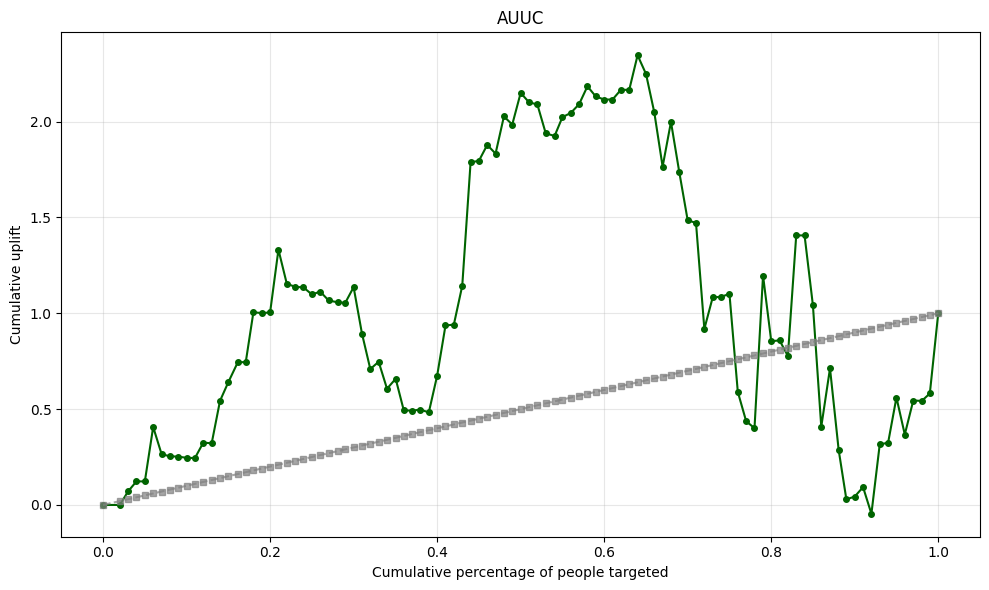

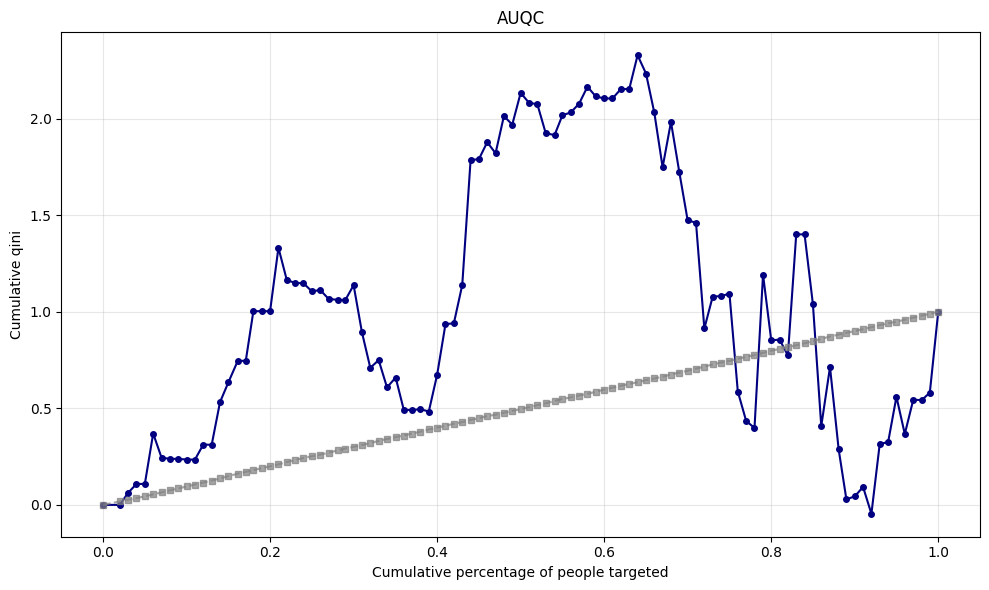

----------------------------------------
1.0294365055704362
1.0238060116345011
0.29498714
0.10740053597196456


In [19]:
print ("Evaluating baseline🔃🔃🔃")
y0_pred, y1_pred, _ = dragonnet.predict(x_women_test_t)

uplift_pred = (y1_pred - y0_pred).numpy().flatten()

y_true = y_women_test_t.numpy().flatten()
t_true = t_women_test_t.numpy().flatten()
auuc = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift = lift(y_true, t_true, uplift_pred, h=0.3,bins=100)
krcc = krcc(y_true, t_true, uplift_pred, bins=100)
print("-"*40)
print (auuc)
print (auqc)
print (lift)
print (krcc)